<h1>Veggie Tales!</h1>

Group members:
- Palaksh V Rungta
- Madison Hambly
- Felipe Lorenzi
- Jacob Schenberg

Dataset: https://www.kaggle.com/kritikseth/fruit-and-vegetable-image-recognition

---

# Setup

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import seaborn as sns

In [32]:
#improve plotting resolution
%config InlineBackend.figure_format ='retina'

---

# Exploration

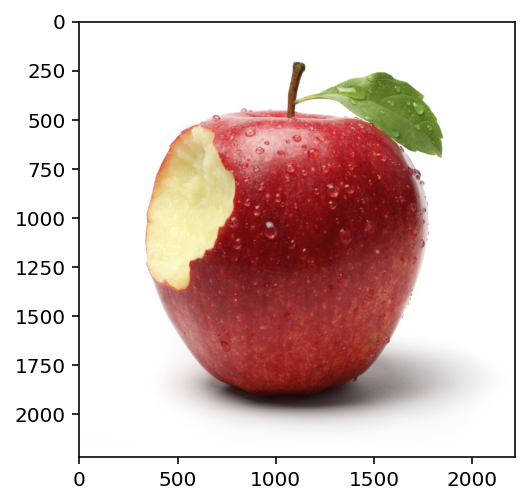

In [33]:
apple_1_fp = './train/apple/Image_1.jpg'
apple_1 = mpimg.imread(apple_1_fp)

plt.imshow(apple_1)

In [4]:
#Dimension of image are 2216 X 2218 with 3 color channels
apple_1.shape

(2216, 2218, 3)

Are the dimensions of every image the same?

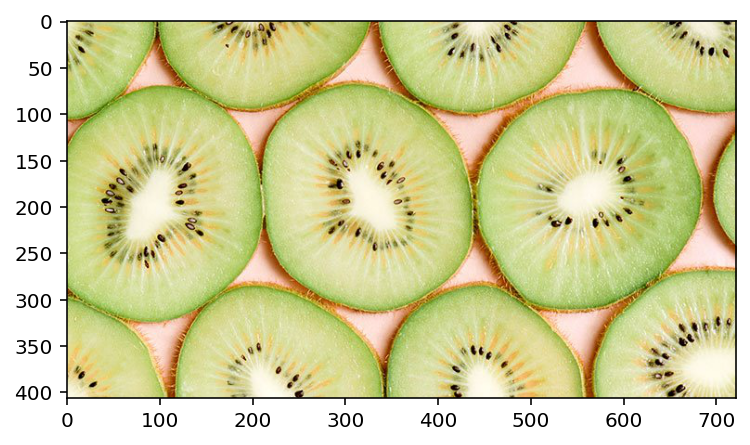

In [34]:
kiwi_fp = './train/kiwi/Image_18.jpg'
kiwi = mpimg.imread(kiwi_fp)

plt.imshow(kiwi)

In [6]:
kiwi.shape

(406, 722, 3)

Doesn't look like it. We will have to crop/resize images

# Cropping and Resizing Images

In order to conduct PCA, we must get all images to be the exact same size.

To do this, we can crop images to be some aspect ratio, then resize them if needed. However, we have to pick which aspect ratio and size we want all of the images to be.

To find these values, we first look at the sizes of all the images in our dataset to see which aspect ratio and size would be most convenient:

In [60]:
def get_size_aspect_ratio(img):
    
    height, width = img.shape[0], img.shape[1]
    
    #GCD means greatest common divisor
    from math import gcd
    gcd_img = gcd(width, height)
    aspect_ratio = (width/gcd_img, height/gcd_img) #ie. aspect ratio of width/gcd : height/gcd
    width_height_ratio = width/height
    
    return [width, height, aspect_ratio, width_height_ratio]

In [69]:
aspect_ratios = pd.DataFrame(columns = ['img_fp', 'width', 'height', 'aspect_ratio', 'width_height_ratio'])

train_dir = './train'
i = 0
for folder in os.listdir(train_dir):
    #Get folder filepath
    folder_dir = os.path.join(train_dir, folder)
    for img_file in os.listdir(folder_dir):
        #Get image filepath
        img_fp = os.path.join(folder_dir, img_file)
        #Read image to array
        try:
            img = mpimg.imread(img_fp)
        except:
            print('ERROR: ' + img_fp)
        #Add data to dataframe
        aspect_ratios.loc[i] = [img_fp] + get_size_aspect_ratio(img)
        i += 1

ERROR: ./train/turnip/Image_22.png


/opt/anaconda3/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:792: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


ERROR: ./train/lemon/Image_73.png


In [97]:
aspect_ratios

img_fp width height      aspect_ratio  \
0      ./train/apple/Image_15.jpg  1067   1600  (1067.0, 1600.0)   
1      ./train/apple/Image_29.jpg   770    433    (770.0, 433.0)   
2      ./train/apple/Image_28.jpg   283    424    (283.0, 424.0)   
3      ./train/apple/Image_14.jpg  1280    720       (16.0, 9.0)   
4      ./train/apple/Image_16.jpg   250    249    (250.0, 249.0)   
...                           ...   ...    ...               ...   
3576  ./train/carrot/Image_27.jpg  1600    977   (1600.0, 977.0)   
3577  ./train/carrot/Image_19.png  1784   2400    (223.0, 300.0)   
3578  ./train/carrot/Image_31.jpg  1180   1124    (295.0, 281.0)   
3579  ./train/carrot/Image_25.jpg  1024    578    (512.0, 289.0)   
3580  ./train/carrot/Image_24.jpg   300    300        (1.0, 1.0)   

      width_height_ratio  
0               0.666875  
1               1.778291  
2               0.667453  
3               1.777778  
4               1.004016  
...                  ...  
3576            1.637666  
3577            0.743333  
3578            1.049822  
3579            1.771626  
3580            1.000000  

[3581 rows x 5 columns]

In [71]:
aspect_ratios['aspect_ratio'].value_counts()[:10]

(1.0, 1.0)          563
(4.0, 3.0)          396
(3.0, 2.0)          219
(2.0, 3.0)          151
(16.0, 9.0)          95
(3.0, 4.0)           89
(2.0, 1.0)           25
(1600.0, 1067.0)     22
(32.0, 35.0)         20
(8.0, 5.0)           20
Name: aspect_ratio, dtype: int64

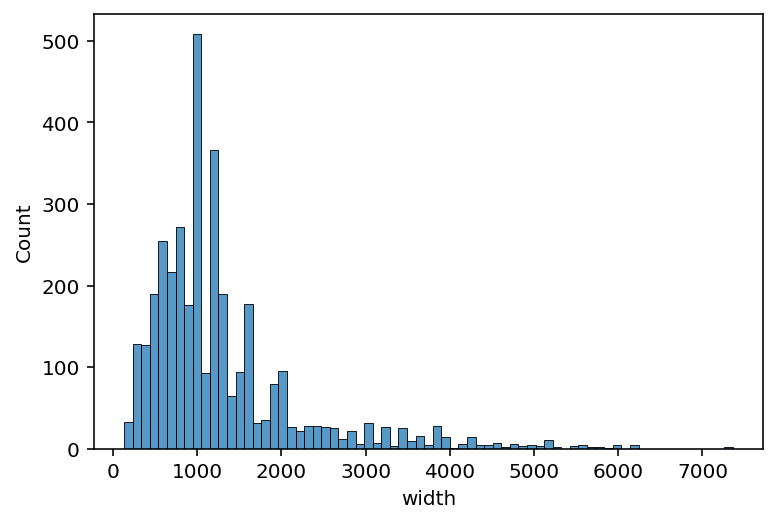

In [72]:
sns.histplot(aspect_ratios['width'])
plt.show()

It looks like the most common aspect ratios are 1:1, 4:3 and 3:2. Furthermore, the most common image width is 1200.

Perhaps then it would be ideal to resize all the images to be 1200 x 1200, using the 1:1 aspect ratio.

In [96]:
# This snippet of code was inspired by https://gist.github.com/zed/4221180
# It was editted slightly to fit our problem

def crop_resize(image, size, ratio):
    
    from PIL import Image
    image = Image.open(image)
    
    # crop to ratio, center
    w, h = image.size
    if w > ratio * h: # width is larger then necessary
        x, y = (w - ratio * h) // 2, 0
    else: # ratio*height >= width (height is larger)
        x, y = 0, (h - w / ratio) // 2
    image = image.crop((x, y, w - x, h - y))

    # resize
    image = image.resize(size)
    
    return image

### Testing on apple_1:

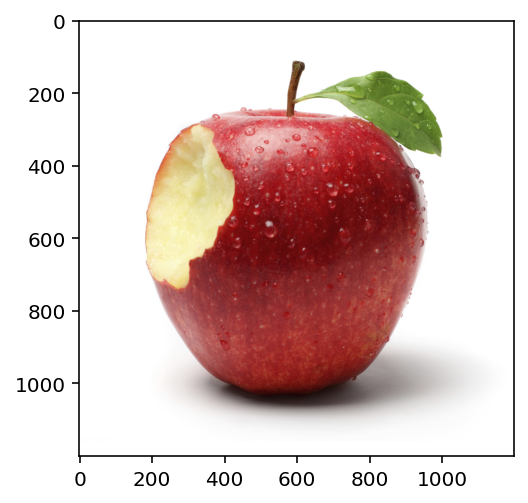

In [92]:
apple_1_resized = np.array(crop_resize(apple_1_fp, (1200, 1200), 1))
plt.imshow(apple_1_resized)

In [93]:
apple_1_resized.shape

(1200, 1200, 3)

Looks like it worked! The proportions of the apple have been preserved, the image is still fairly high-resolution and it has been reshaped correctly. 

Let's test this for a few different images to make sure.

Pomegranate/Image_3 looks to be slightly off-center. Let's see how it looks after resizing:

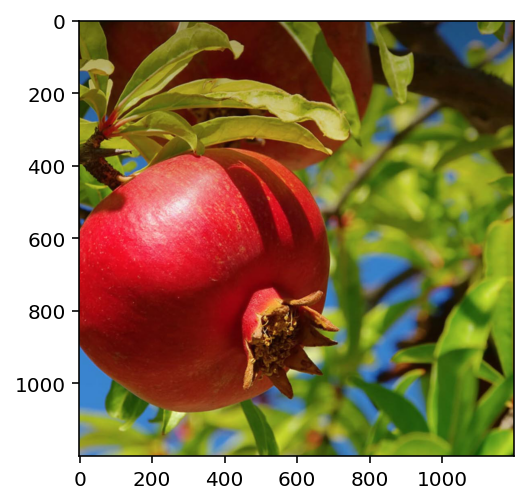

In [94]:
pomegranate_3_resized = np.array(crop_resize('./train/pomegranate/Image_3.jpg', (1200, 1200), 1))
plt.imshow(pomegranate_3_resized)

In [95]:
pomegranate_3_resized.shape

(1200, 1200, 3)

The pomegranate is slightly off-center but this seems like a decent solution.

Jalapeno/Image_53 is very small. Let's see how the resizing algorithm works in that case:

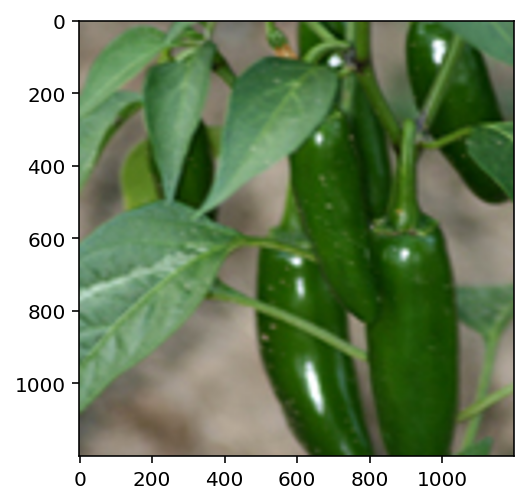

In [110]:
jalapeno_53_resized = np.array(crop_resize('./train/jalepeno/Image_53.jpg', (1200, 1200), 1))
plt.imshow(jalapeno_53_resized)

In [100]:
jalapeno_53_resized.shape

(1200, 1200, 3)

The image is not very clear, as is to be expected, but nothing weird is happening. This looks solid.

### Cropping and resizing all images and exporting them
Here we crop and resize all images to be 1200x1200, then export them to a new folder for posteriority.

# PCA